In [47]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from koopman.simulation.animation import PlotEnvironment
from koopman.simulation.systems import DynamicalSystem, Pendulum
from IPython.display import HTML

In [31]:
# Constants
g = 9.81      # gravity
l = 1.0       # length
m = 1.0       # mass
dt = 0.05     # timestep
tf = 10.0
N = int(tf / dt)  # number of timesteps
nx = 2
nu = 1

# Cost matrices
Q = np.diag([1.0, 0.1])        # State cost
R = np.diag([0.01])            # Control cost
Qf = 100 * Q                         # Terminal cost
x0_val = np.array([0.0, 0.0])
xf_val = np.array([np.pi, 0.0])


def dynamics(x, u):
    theta = x[0, 0]
    theta_dot = x[1, 0]    
    theta_ddot = -(g/l) * ca.sin(theta) + (1/(m*l**2)) * u
    return ca.vertcat(theta_dot, theta_ddot)

def rk4(x, u, h):    
    k1 = dynamics(x, u)
    k2 = dynamics(x + 0.5 * h * k1, u)
    k3 = dynamics(x + 0.5 * h * k2, u)
    k4 = dynamics(x + h * k3, u)
    
    return x + (h/6) * (k1 + 2*k2 + 2*k3 + k4)


In [49]:
X = ca.MX.sym('X', nx, N + 1)
U = ca.MX.sym('U', nu, N)

cost = 0
ineq = []

for k in range(N):
    xk = X[:, k]
    uk = U[:, k]
    xk_next = X[:, k+1]

    # Stage cost
    xerr = xk - xf_val
    cost += ca.mtimes([xerr.T, Q, xerr])
    cost += ca.mtimes([uk.T, R, uk])

    # Dynamics constraint
    xk_next_pred = rk4(xk, uk, dt)
    ineq.append(xk_next - xk_next_pred)

# Terminal cost
xerr_terminal = X[:, N] - xf_val
cost += ca.mtimes([xerr_terminal.T, Qf, xerr_terminal])

# Initial condition constraint
ineq.insert(0, X[:, 0] - x0_val)

ineq_flat = ca.vertcat(*ineq)

# Define decision variables
opt_vars = ca.vertcat(
    ca.reshape(X, nx * (N + 1), 1),
    ca.reshape(U, nu * N, 1)
)

In [55]:
# Create NLP
nlp = {'x': opt_vars, 'f': cost, 'g': ineq_flat}

# Solver
solver = ca.nlpsol('solver', 'ipopt', {'x': opt_vars, 'f': cost, 'g': ineq_flat},
                   {'ipopt.print_level': 0, 'print_time': 0})

# Initial guess
x0_guess = np.tile(np.zeros((nx, 1)), (N+1, 1))
u0_guess = np.random.randn(nu, N)
x0u0 = np.concatenate([x0_guess.flatten(), u0_guess.flatten()])

lbg = ubg = np.zeros(ineq_flat.shape)

x_min = -ca.inf * np.ones((nx, N + 1))
x_max = ca.inf * np.ones((nx, N + 1))
u_min = -2.0 * np.ones((nu, N))
u_max = 2.0 * np.ones((nu, N))

lbx = np.concatenate([x_min.flatten(), u_min.flatten()])
ubx = np.concatenate([x_max.flatten(), u_max.flatten()])

sol = solver(x0=x0u0, lbg=lbg, ubg=ubg, lbx=lbx, ubx=ubx)

stats = solver.stats()
print(f"Solver statistics:")
print(f"\titer_count: {stats['iter_count']}")
print(f"\treturn_status: {stats['return_status']}")

for k in stats:
    if k.startswith('t_'):
        print(f"\t{k}: {stats[k]}")

Solver statistics:
	iter_count: 306
	return_status: Solve_Succeeded
	t_proc_callback_fun: 0.0
	t_proc_nlp_f: 0.007797999999999991
	t_proc_nlp_g: 0.02577300000000003
	t_proc_nlp_grad: 0.0
	t_proc_nlp_grad_f: 0.012374000000000008
	t_proc_nlp_hess_l: 0.15221799999999983
	t_proc_nlp_jac_g: 0.08758799999999996
	t_wall_callback_fun: 0.0
	t_wall_nlp_f: 0.007845671000000002
	t_wall_nlp_g: 0.02542958999999999
	t_wall_nlp_grad: 0.0
	t_wall_nlp_grad_f: 0.012403991999999999
	t_wall_nlp_hess_l: 0.15196291899999992
	t_wall_nlp_jac_g: 0.08753733200000005


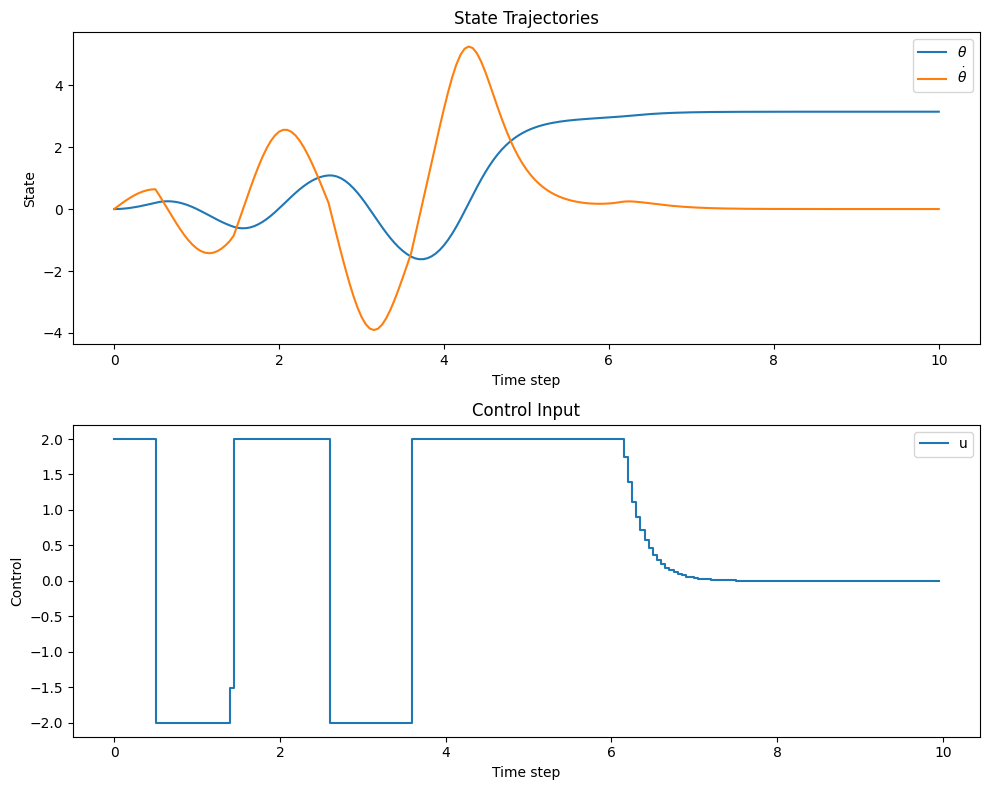

In [56]:
opt = sol['x'].full().flatten()
X_opt = opt[:nx*(N+1)].reshape((N+1, nx))
U_opt = opt[nx*(N+1):].reshape((N, nu))

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ts = np.arange(0, tf + dt, dt)

ax[0].plot(ts, X_opt[:, 0], label=r'$\theta$')
ax[0].plot(ts, X_opt[:, 1], label=r'$\dot{\theta}$')
ax[0].set_title('State Trajectories')
ax[0].set_xlabel('Time step')
ax[0].set_ylabel('State')
ax[0].legend()

ax[1].step(ts[:-1], U_opt[:, 0], label='u', where='post')
ax[1].set_title('Control Input')
ax[1].set_xlabel('Time step')
ax[1].set_ylabel('Control')
ax[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
ts = np.arange(0, tf + dt, dt)
sys = Pendulum(Pendulum.Params(m=m, l=l, g=g))
sys.set_history(ts, X_opt.squeeze(), U_opt.squeeze())

# Render the simulation
fig, ax = plt.subplots(figsize=(5, 5))
ax.grid(True)
ax.set_aspect('equal')

env = PlotEnvironment(fig, ax)
env.add_element(Pendulum.PlotElement(env, sys))
ani = env.render(t_range=(0, tf), fps=30)

HTML(ani.to_html5_video())

<IPython.core.display.Javascript object>

/Users/micahreich/Documents/koopman/venv/lib/python3.10/site-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(
